# Concrete Image Classification
By: Anthony Sheu

This project uses a 50/50 split dataset of positive (with cracks) and negative (without cracks) images of concrete. The data was obtained from https://data.mendeley.com/datasets/5y9wdsg2zt/2.

This binary classification model aims to be able to guess whether a provided image is positive or negative. Firstly, the images are randomly put in a 80% training, 20% validation split. Then the images will be pre-processed using transformations and finally fed through a pre-built CNN network with transfer learning to only modify the last layer (ResNet-18). The libraries used in this project are Pytorch (for deep learningm models) and torchvision (for transformations, training, and inferencing). The metrics will be tracked using WANDB and further analyzed.

In [20]:
%pip install -q matplotlib wandb scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install -q pytorch_lightning

Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install -q torch torchvision --index-url https://download.pytorch.org/whl/cu118

Note: you may need to restart the kernel to use updated packages.


## Example Images
Below is an image of a NEGATIVE (left) and POSITIVE (right) concrete crack.

In [4]:
from IPython.display import display, HTML

display(HTML(
"""
    <div style="display: flex; gap: 20px; text-align: center;">
    <div>
        <img src="samples/negative.jpg" width="300"><br>
        <strong>Negative</strong>
    </div>
    <div>
        <img src="samples/positive.jpg" width="300"><br>
        <strong>Positive</strong>
    </div>
    </div>
"""
))

## Image Augmentation
Now the data will be augmented with normalizations, resizing, etc. The reason is to expand the diversity of the training set and to ensure that my model is generalizeable over variations of data. It also helps simulate real-world variations such as different lighting, different colours, various positions, and noise/blur. 
Since I will be using the pre-trained ResNet-18 model, the images will be resized to 224 x 224 pixels. The reason is because ResNet-18 was originally trained on ImageNet where the images were resizd to 224 x 224. Then normalization values will be mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225], as these were the values used in training.

Information from https://docs.pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html

A very basic transformation would look as follows.

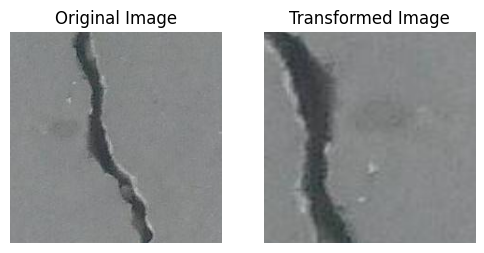

In [5]:
import matplotlib.pyplot as plt
import torchvision.transforms as tf
from PIL import Image

def showTransform():
    image_path = "samples/positive.jpg"
    image = Image.open(image_path)

    # original image
    plt.figure(figsize=(6, 3))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Original Image")
    plt.axis("off")

    transformed_image = transform(image)
    transformed_image = transformed_image.permute(1, 2, 0) 
    transformed_image = transformed_image.numpy()

    # transformed image
    plt.subplot(1, 2, 2)
    plt.imshow(transformed_image)
    plt.title("Transformed Image")
    plt.axis("off")
    plt.show()



# transformations
transform = tf.Compose([
    tf.RandomResizedCrop(size = (224, 224), antialias=True),
    tf.RandomHorizontalFlip(),  
    tf.RandomVerticalFlip(),
    tf.ToTensor(),              
    # tf.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
showTransform()

Now we can experiment with other types of transformations such as random erasing, Gaussian blur, and random rotations.

### Random Erasing

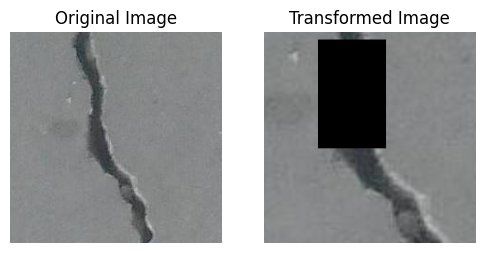

In [6]:
# transformations
transform = tf.Compose([
    tf.RandomResizedCrop(size = (224, 224), antialias=True),
    tf.RandomHorizontalFlip(),  
    tf.RandomVerticalFlip(),
    tf.ToTensor(),              
    # tf.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    tf.RandomErasing(p = 0.5, scale = (0.02, 0.25)),
])

showTransform()

https://docs.pytorch.org/vision/main/generated/torchvision.transforms.v2.RandomErasing.html#torchvision.transforms.v2.RandomErasing

### Gaussian Blur

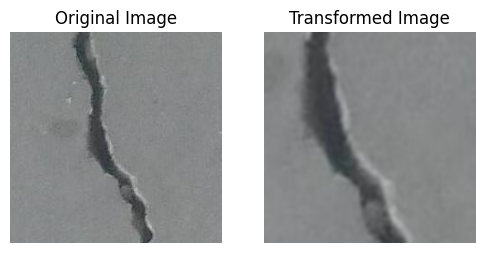

In [7]:
# transformations
transform = tf.Compose([
    tf.RandomResizedCrop(size = (224, 224), antialias=True),
    tf.RandomHorizontalFlip(),  
    tf.RandomVerticalFlip(),
    tf.GaussianBlur(kernel_size = (5, 5), sigma = (0.1, 2)),
    tf.ToTensor(),              
    # tf.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

showTransform()

https://docs.pytorch.org/vision/main/generated/torchvision.transforms.v2.GaussianBlur.html#torchvision.transforms.v2.GaussianBlur

### Random Rotation

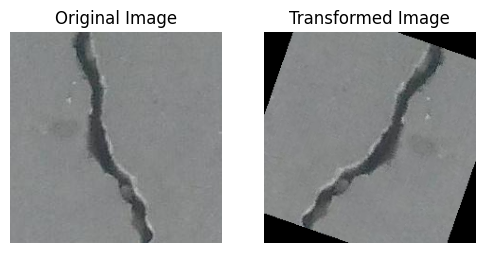

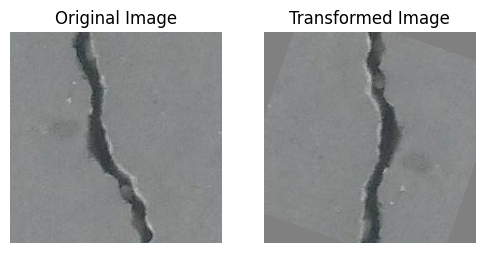

In [8]:
# transformations
transform = tf.Compose([
    tf.RandomRotation(degrees = (-30, 30)),
    tf.CenterCrop(224),
    tf.RandomHorizontalFlip(),  
    tf.RandomVerticalFlip(),
    tf.ToTensor(),              
    # tf.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

showTransform()

# transformations
transform = tf.Compose([
    tf.RandomRotation(degrees = (-30, 30), expand = False, fill = (128, 128, 128)),
    tf.CenterCrop(224),
    tf.RandomHorizontalFlip(),  
    tf.RandomVerticalFlip(),
    tf.ToTensor(),              
    # tf.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

showTransform()

When using random rotation, an issue came up where the rotation would cause parts of the image to be filled in with black pixels. This is because the square image rotated in any direction would cause it to essentially not be a square anymore (from the same perspective). I resorted to adding in filler grey pixels and only cropping from the center to minimize the amount of filler space and maximize the amount of actual data area.
https://docs.pytorch.org/vision/main/generated/torchvision.transforms.v2.RandomRotation.html#torchvision.transforms.v2.RandomRotation

### Final Transformations
My final verdict on which transformations to use to train the model is to try them all. I will be using 

1. Basic normal transformations
2. Random Erasing
3. Gaussian Blur
4. Random Rotation
5. Everything all at once

and comparing the metrics between each. These transformtions are just the ones from this list (https://docs.pytorch.org/vision/main/transforms.html) that seemed the most effective at creating variation in the training set to me.

## Creating the Model
Since I will be using a pre-trained model, I just have to make sure that I freeze all the previous layers and only train the last layer to perform transfer learning (and to save time). The code is displayed below.

In [ ]:
import torch
import torchvision.models
import torch.nn.functional as F
import pytorch_lightning as pl
from sklearn.metrics import precision_score, recall_score

class NeuralNet(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = torchvision.models.resnet18(pretrained = True)

        # freeze pre-trained layers
        for param in self.model.parameters():
            param.requires_grad = False

        self.model.eval()

        num_ftrs = self.model.fc.in_features
        self.model.fc = torch.nn.Linear(num_ftrs, 2)

        # unfreeze final classification layer
        for param in self.model.fc.parameters():
            param.requires_grad = True

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        self.log("train_loss", loss)
        return loss

    def validation_step(self,batch,batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        acc = (logits.argmax(dim = 1) == y).float().mean()
        y_hat = self(x)
        preds = torch.argmax(y_hat, dim = 1)
        precision = precision_score(y.cpu(), preds.cpu(), average = 'macro', zero_division = 0)
        recall = recall_score(y.cpu(), preds.cpu(), average = 'macro', zero_division = 0)
        self.log("val_loss", loss)
        self.log("val_acc", acc)
        self.log("precision", precision)
        self.log("recall", recall)
        return {"val_loss": loss, "val_acc": acc, "val_precision": precision, "val_recall": recall}

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr = 1e-3)

## Loading data
The class below is responsible for loading the data and supplying the correct transformation for each of the 5 test cases. "transform" will be a global variable that we can just specify each time before we run it.

In [15]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import os

class Data(pl.LightningDataModule):
    def __init__(self, dir="data", size = 32):
        super().__init__()
        self.data_dir = dir
        self.batch_size = size
        self.transform = transform
    
    def setup(self, stage=None):
        self.train_data = ImageFolder(os.path.join(self.data_dir, 'train'), transform = self.transform)
        self.val_data = ImageFolder(os.path.join(self.data_dir, 'val'), transform = self.transform)
    
    def train_dataloader(self):
        return DataLoader(self.train_data, batch_size = self.batch_size, shuffle = True)
    
    def val_dataloader(self):
        return DataLoader(self.val_data, batch_size = self.batch_size)


## Testing with Basic Transformations
The first test will be using basic transformations: random resized crop, random horizontal flip, random vertical flip.

In [18]:
from pytorch_lightning.loggers import WandbLogger

transform = tf.Compose([
    tf.RandomResizedCrop(size = (224, 224), antialias=True),
    tf.RandomHorizontalFlip(),  
    tf.RandomVerticalFlip(),
    tf.ToTensor(),              
    tf.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

model = NeuralNet()
data_module = Data()
wandb_logger = WandbLogger(project = "anomaly-detection", name = "resnet18-run")
trainer = pl.Trainer(max_epochs = 5, logger = wandb_logger, devices = 1, accelerator = "gpu")
trainer.fit(model, data_module)

c:\Users\antho\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\antho\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, usin

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type   | Params | Mode
----------------------------------------
0 | model | ResNet | 11.2 M | eval
----------------------------------------
1.0 K     Trainable params
11.2 M    Non-trainable params
11.2 M    Total params
44.710    Total estimated model params size (MB)
1         Modules in train mode
67        Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\antho\AppData\Local\Programs\Python\Python313\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


c:\Users\antho\AppData\Local\Programs\Python\Python313\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Epoch 4: 100%|██████████| 1000/1000 [01:32<00:00, 10.78it/s, v_num=ugfx]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1000/1000 [01:32<00:00, 10.76it/s, v_num=ugfx]


## 1. Basic Transformations Metrics
The metrics tracked by wandb were 

1. val_loss (how well the model performs on unseen/testing data)
2. val_acc (validation accuracy % of correct predictions)
3. train_loss (how well the model is performing on the training dataset)
4. precision (quantifies how many of the positive predictions were actually positive)
5. recall (quantifies how many of the positive observations were identified as positive)